# Adaptive to AR strength of dependence

We illustrate `EnIF` comparatively with `EnKF` methodology through the Auto-Regressive-1 (AR-1) model.
The AR-1 is defined by
$$u_t = \phi u_{t-1} + \epsilon,~~
 \epsilon\sim N(0,1) $$
and has a tri-diagonal sparse precision matrix.

The AR-1 process is convenient in showcasing EnIF in face of no dependence ($\phi=0.0$), medium dependence ($\phi=0.5$) and strong dependence ($\phi=0.9$).

## Imports

In [28]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import scipy as sp
from scipy.stats import norm
import matplotlib.pyplot as plt
from graphite_maps.precision_estimation import precision_to_graph
from graphite_maps.enif import EnIF

## Data setup: Auto-regressive simulation

We define the parameters of the ensemble based data assimilation with the AR-1
- `n`: ensemble or sample size. Increasing will increase the quality of the solution
- `p`: the number of AR-1 time-steps, here the dimensions of the problem. Increasing yields a more difficult problem. Traditional ensemble based methods would use localization to deal with high `p`.
- `phi`: between `-1` and `1`. `0` yields white noise without dependence. When `abs(phi)` is close to `1` there is strong dependence between dimensions.
- - Suggest to try `phi in [-0.99, 0.5, 0, 0.5, 0.99]` and inspect differences.

In [29]:
# Define parameters
n = 50  # Sample size
p = 100   # Dimension
phi0 = 0.0
phi1 = 0.5
phi2 = 0.9
phi3 = 0.95

In [30]:
# Simulate data
def rar1(T, phi):
    """simulate auto-regressive-1.
    The first element is simulated from stationary distribution.
    """
    x = np.empty([T])
    x[0] = np.random.normal(0, 1 / np.sqrt(1 - phi**2))
    for i in range(1, T):
        x[i] = phi * x[i - 1] + np.random.normal(0, 1)
    return x

np.random.seed(42)
U0 = np.array([rar1(T=p, phi=phi0) for _ in range(n)])
U1 = np.array([rar1(T=p, phi=phi1) for _ in range(n)])
U2 = np.array([rar1(T=p, phi=phi2) for _ in range(n)])
U3 = np.array([rar1(T=p, phi=phi3) for _ in range(n)])

We here know the precision exactly, so we may compare our estimates. Note we derive the graph `Graph_u` from the precision, which we would normally just know apriori, while `Prec_u` would often (not always) be unknown.

In [31]:
# create AR-1 precision matrix
Prec_u0 = sp.sparse.diags(
    [np.repeat(-phi0, p-1), np.concatenate(([1.0], np.repeat(1.0+phi0**2, p-2), [1.0])), np.repeat(-phi0, p-1)], 
    [-1,0,1], shape=(p, p), 
    format='csc'
)
Prec_u1 = sp.sparse.diags(
    [np.repeat(-phi1, p-1), np.concatenate(([1.0], np.repeat(1.0+phi1**2, p-2), [1.0])), np.repeat(-phi1, p-1)], 
    [-1,0,1], shape=(p, p), 
    format='csc'
)
Prec_u2 = sp.sparse.diags(
    [np.repeat(-phi2, p-1), np.concatenate(([1.0], np.repeat(1.0+phi2**2, p-2), [1.0])), np.repeat(-phi2, p-1)], 
    [-1,0,1], shape=(p, p), 
    format='csc'
)
Prec_u3 = sp.sparse.diags(
    [np.repeat(-phi3, p-1), np.concatenate(([1.0], np.repeat(1.0+phi3**2, p-2), [1.0])), np.repeat(-phi3, p-1)], 
    [-1,0,1], shape=(p, p), 
    format='csc'
)

# create corresponding graph -- often we only know this
Graph_u0 = precision_to_graph(Prec_u0)
Graph_u1 = precision_to_graph(Prec_u1)
Graph_u2 = precision_to_graph(Prec_u2)
Graph_u3 = precision_to_graph(Prec_u3)

Create observations, `d`, that are associated with `u`.
We here pass a linear map `H` so that we model $d=Hu+\epsilon$, and $\epsilon$ has known precision.
Note that `H` may be learnt from data using the `fit_H` function.
We must then pass realizations `U` and simulated responses `Y`.

In [32]:
# create observation
d = np.array([20.0])
sd_eps = 1
H = np.array([0] * p, ndmin=2)
H[0, p-1] = 1 # sensor at endpoint
#H[0, np.rint(p / 2).astype(int) - 1] = 1  # middle sencor
H = sp.sparse.csc_matrix(H)
Prec_eps = np.array([1/sd_eps**2], ndmin=2)
Prec_eps = sp.sparse.csc_matrix(Prec_eps)

In [33]:
# create responses
Y0 = U0@H.T
Y1 = U1@H.T
Y2 = U2@H.T
Y3 = U3@H.T

## ES update

In [34]:
def ES(U, Y, d, Cov_epsilon):
    # Cross-covariance matrix C_UY has shape (p, m)
    n, m = Y.shape
    C_UY = np.dot((U - U.mean(axis=0)).T, (Y - Y.mean(axis=0))) / (n - 1)
    print(C_UY.shape)

    # Compute the covariance of Y
    # Covariance matrix C_YY has shape (m, m)
    C_YY = np.dot((Y - Y.mean(axis=0)).T, (Y - Y.mean(axis=0))) / (n - 1)

    print(C_YY.shape)

    # Estimated K
    K = C_UY @ np.linalg.inv(C_YY + Cov_epsilon)
    print(K.shape)
    
    # perturb observations
    n, m = Y.shape
    eps = np.random.normal(loc=0, scale=np.sqrt(Cov_epsilon.diagonal()), size=(n,m))
    di = d - eps

    U_posterior = np.copy(U)
    for i in range(n):
        U_posterior[i,:] += K @ (di[i] - Y[i,:])
    
    return U_posterior

In [35]:
U_posterior_es0 = ES(U0, Y0, d, np.linalg.inv(Prec_eps.A))
U_posterior_es1 = ES(U1, Y1, d, np.linalg.inv(Prec_eps.A))
U_posterior_es2 = ES(U2, Y2, d, np.linalg.inv(Prec_eps.A))
U_posterior_es3 = ES(U3, Y3, d, np.linalg.inv(Prec_eps.A))

(100, 1)
(1, 1)
(100, 1)
(100, 1)
(1, 1)
(100, 1)
(100, 1)
(1, 1)
(100, 1)
(100, 1)
(1, 1)
(100, 1)


## EnIF update

In [36]:
gtmap0 = EnIF(Graph_u = Graph_u0, Prec_eps=Prec_eps, H=H)
gtmap0.fit(U0, verbose_level=0)
U_posterior_enif0 = gtmap0.transport(U0, Y0, d, seed=42, verbose_level=0)

gtmap1 = EnIF(Graph_u = Graph_u1, Prec_eps=Prec_eps, H=H)
gtmap1.fit(U1, verbose_level=0)
U_posterior_enif1 = gtmap1.transport(U1, Y1, d, seed=42, verbose_level=0)

gtmap2 = EnIF(Graph_u = Graph_u2, Prec_eps=Prec_eps, H=H)
gtmap2.fit(U2, verbose_level=0)
U_posterior_enif2 = gtmap2.transport(U2, Y2, d, seed=42, verbose_level=0)

gtmap3 = EnIF(Graph_u = Graph_u3, Prec_eps=Prec_eps, H=H)
gtmap3.fit(U3, verbose_level=0)
U_posterior_enif3 = gtmap3.transport(U3, Y3, d, seed=42, verbose_level=0)

Learning precision Cholesky factor row-by-row: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3157.46it/s]


## Exact update

In [37]:
gtmap_prec_known0 = EnIF(Prec_u = Prec_u0, Prec_eps=Prec_eps, H=H)
U_posterior0 = gtmap_prec_known0.transport(U0, Y0, d)

gtmap_prec_known1 = EnIF(Prec_u = Prec_u1, Prec_eps=Prec_eps, H=H)
U_posterior1 = gtmap_prec_known1.transport(U1, Y1, d)

gtmap_prec_known2 = EnIF(Prec_u = Prec_u2, Prec_eps=Prec_eps, H=H)
U_posterior2 = gtmap_prec_known2.transport(U2, Y2, d)

gtmap_prec_known3 = EnIF(Prec_u = Prec_u3, Prec_eps=Prec_eps, H=H)
U_posterior3 = gtmap_prec_known3.transport(U3, Y3, d)

## Plotting

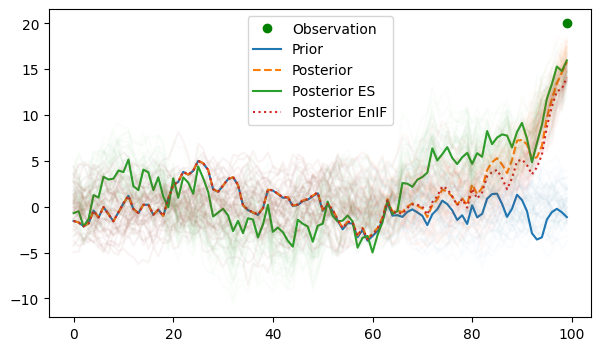

In [38]:
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
u_position = [j for j in range(p)]

# Setup figure
plt.figure(figsize=(7,4))

# Plot data
plt.plot(u_position[-1], d, 'go', label=f'Observation')
plt.plot(u_position, U2[0,:], label="Prior", color=COLORS[0])
plt.plot(u_position, U_posterior2[0,:], label="Posterior", linestyle="--", color=COLORS[1])
plt.plot(u_position, U_posterior_es2[0,:], label="Posterior ES", linestyle='solid', color=COLORS[2])
plt.plot(u_position, U_posterior_enif2[0,:], label="Posterior EnIF", linestyle='dotted', color=COLORS[3])

for i in range(n):
    plt.plot(u_position, U2[i,:], color=COLORS[0], alpha=0.02)

for i in range(n):
    plt.plot(u_position, U_posterior2[i,:], color=COLORS[1], alpha=0.02)

for i in range(n):
    plt.plot(u_position, U_posterior_es2[i,:], color=COLORS[2], alpha=0.02)

for i in range(n):
    plt.plot(u_position, U_posterior_enif2[i,:], color=COLORS[3], alpha=0.02)#, linestyle='--')


# Annotate figure

plt.legend()

if True:
    plt.savefig("adaptive_strength_of_dependence.pdf", format='pdf', bbox_inches='tight')

plt.show()

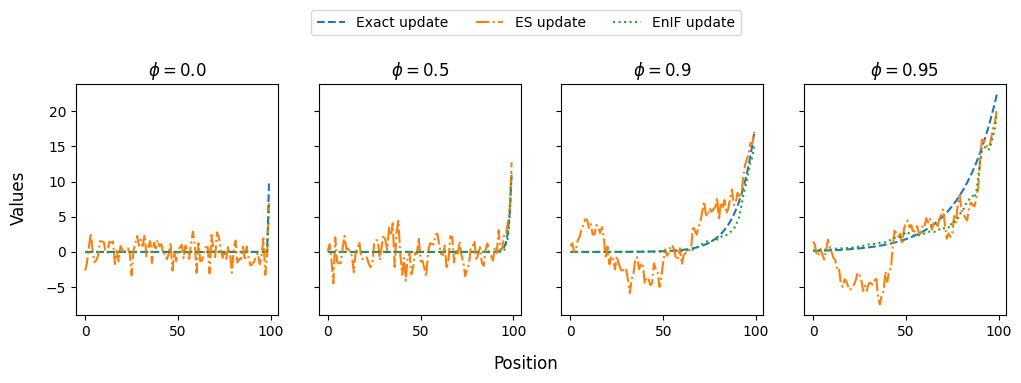

In [53]:
import matplotlib.pyplot as plt

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
u_position = [j for j in range(p)]

def plot_subplot(ax, u_position, d, U, U_posterior, U_posterior_es, U_posterior_enif, n):
    """ Function to create the individual plots on the given subplot axis """
    # Plot data
    #ax.plot(u_position[-1], d, 'go', label=f'Observation')
    #ax.plot(u_position, U[0, :], label="Prior", color=COLORS[0])
    ax.plot(u_position, U_posterior[0, :]-U[0, :], label="Exact update", linestyle="--")#, color=COLORS[0])
    ax.plot(u_position, U_posterior_es[0, :]-U[0, :], label="ES update", linestyle='-.')#, color=COLORS[1])
    ax.plot(u_position, U_posterior_enif[0, :]-U[0, :], label="EnIF update", linestyle='dotted')#, color=COLORS[2])

    #for i in range(n):
    #    ax.plot(u_position, U[i, :], color=COLORS[0], alpha=0.02)
    #    ax.plot(u_position, U_posterior[i, :], color=COLORS[1], alpha=0.02)
    #    ax.plot(u_position, U_posterior_es[i, :], color=COLORS[2], alpha=0.02)
    #    ax.plot(u_position, U_posterior_enif[i, :], color=COLORS[3], alpha=0.02)

# Create a figure with 3 subplots (horizontal layout)
fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharey=True)

# Plot for index 0 using datasets U0, U_posterior0, U_posterior_es0, U_posterior_enif0
plot_subplot(axes[0], u_position, d, U0, U_posterior0, U_posterior_es0, U_posterior_enif0, n)
axes[0].set_title(f'$\phi=${phi0}')

# Plot for index 1 using datasets U1, U_posterior1, U_posterior_es1, U_posterior_enif1
plot_subplot(axes[1], u_position, d, U1, U_posterior1, U_posterior_es1, U_posterior_enif1, n)
axes[1].set_title(f'$\phi=${phi1}')

# Plot for index 2 using datasets U2, U_posterior2, U_posterior_es2, U_posterior_enif2
plot_subplot(axes[2], u_position, d, U2, U_posterior2, U_posterior_es2, U_posterior_enif2, n)
axes[2].set_title(f'$\phi=${phi2}')

plot_subplot(axes[3], u_position, d, U3, U_posterior3, U_posterior_es3, U_posterior_enif3, n)
axes[3].set_title(f'$\phi=${phi3}')

# Create a common legend for all subplots, placed outside the plot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

# Set common x and y labels
fig.text(0.5, -0.07, 'Position', ha='center', fontsize=12)
fig.text(0.07, 0.5, 'Values', va='center', rotation='vertical', fontsize=12)

# Save the figure
if True:
    plt.savefig("adaptive_strength_of_dependence_multiplot.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()
